# モデル選択

- [Model selection: choosing estimators and their parameters](http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html)
- [3.1. Cross-validation: evaluating estimator performance](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance)

# スコアとクロスバリデーションスコア

- 全てのモデルにscoreメソッドがある。この値が大きい方が良い。
- 注）二乗誤差の場合もマイナスをつけて、無理やり大きい方が良くなるようにしている。二乗誤差がマイナスの値をとっているのはそのため。

In [1]:
from sklearn import datasets, svm

In [2]:
digits = datasets.load_digits()

In [3]:
X_digits = digits.data
y_digits = digits.target

In [4]:
svc = svm.SVC(C=1, kernel='linear')

In [5]:
svc.fit(X_digits[:-100], y_digits[:-100]).score(X_digits[-100:], y_digits[-100:])

0.97999999999999998

でも、この予測精度って信頼できるの？

In [6]:
import numpy as np

In [7]:
n_fold = 3

In [8]:
X_folds = np.array_split(X_digits, n_fold)

In [9]:
y_folds = np.array_split(y_digits, n_fold)

In [10]:
scores = list()

In [11]:
for k in range(n_fold):
    X_train = list(X_folds)
    X_test = X_train.pop(k)
    X_train = np.concatenate(X_train)
    
    y_train = list(y_folds)
    y_test = y_train.pop(k)
    y_train = np.concatenate(y_train)
    
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))

In [12]:
print(scores)

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]


- この方法はK fold cross-validation 
- 毎回このコードを書くのは面倒臭い

## クロスバリデーションジェネレータ

[Cross-validation generators](http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html#cross-validation-generators)

In [13]:
from sklearn import cross_validation

In [14]:
k_fold = cross_validation.KFold(n=6, n_folds=3)

In [15]:
for train_indices, test_indices in k_fold:
    print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [2 3 4 5] | test: [0 1]
Train: [0 1 4 5] | test: [2 3]
Train: [0 1 2 3] | test: [4 5]


これを使えばクロスバリデーションがカンタンにできる

In [16]:
kfold = cross_validation.KFold(len(X_digits), n_folds=3)
[svc.fit(X_digits[train], y_digits[train]).score(X_digits[test], y_digits[test])
        for train, test in kfold]

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]

In [17]:
cross_validation.cross_val_score(svc, X_digits, y_digits, 
                                 cv=kfold, 
                                 n_jobs=-1) # CPU全部使うということ

array([ 0.93489149,  0.95659432,  0.93989983])

Cross-validation generators
- KFold(n, k)
- StratifiedKFold(y, k)
- LeaveOneOut(n)
- LeaveOneLabelOut(labels)

練習問題

On the digits dataset, plot the cross-validation score of a SVC estimator with an linear kernel as a function of parameter C (use a logarithmic grid of points, from 1 to 10).

In [18]:
import numpy as np
from sklearn import cross_validation, datasets, svm

digits = datasets.load_digits()
X = digits.data
y = digits.target

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

## 方法１

In [19]:
np.random.seed(0)

all_scores = []
for C in C_s:
    scores = []
    skfold = cross_validation.StratifiedKFold(y, n_folds=5)
    for train, test in skfold:
        svc.set_params(C=C)
        svc.fit(X[train], y[train])
        score = svc.score(X[test], y[test])
        scores.append(score)
    all_scores.append(scores)

In [20]:
all_scores = np.array(all_scores)

In [21]:
m = all_scores.mean(axis=1)
s = all_scores.std(axis=1)

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt 

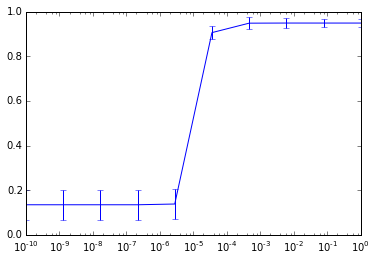

In [23]:
plt.errorbar(C_s, m, yerr=s)
plt.xscale("log")

In [24]:
C_s[np.argmax(m)]

0.0059948425031894209

## 方法２

In [25]:
np.random.seed(0)

scores = []

for C in C_s:
    skfold = cross_validation.StratifiedKFold(y, n_folds=10)
    svc.C = C
    this_scores = cross_validation.cross_val_score(svc, X, y, n_jobs=-1, cv=skfold)
    scores.append(this_scores)

In [26]:
scores = np.array(scores)

In [27]:
m = scores.mean(axis=1)
s = scores.std(axis=1)

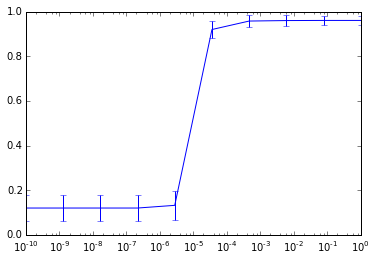

In [28]:
plt.errorbar(C_s, m, yerr=s)
plt.xscale("log")

In [29]:
C_s[np.argmax(m)]

0.077426368268112777

## グリッドサーチとcross-validated estimators

[Grid-search and cross-validated estimators](http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html#grid-search-and-cross-validated-estimators)

In [30]:
# デフォルトだと3-fold cross-validationを使う。
# 分類の場合はstratified 3-fold cross-validationを使う。
from sklearn.grid_search import GridSearchCV

In [31]:
Cs = np.logspace(-6, -1, 10)

In [32]:
clf = GridSearchCV(estimator=svc, 
                   param_grid=dict(C=Cs), 
                   n_jobs=-1)

In [33]:
clf.fit(X_digits[:1000], y_digits[:1000])

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'C': array([  1.00000e-06,   3.59381e-06,   1.29155e-05,   4.64159e-05,
         1.66810e-04,   5.99484e-04,   2.15443e-03,   7.74264e-03,
         2.78256e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [34]:
clf.best_score_

0.92500000000000004

In [35]:
clf.best_estimator_.C

0.0077426368268112772

In [36]:
clf.score(X_digits[1000:], y_digits[1000:])

0.94353826850690092

## Cross-validated estimators

- 自動的にCVをやって、最適パラメータを見つけてくれる

In [37]:
from sklearn import linear_model, datasets

In [38]:
lasso = linear_model.LassoCV()

In [39]:
diabetes = datasets.load_diabetes()

In [40]:
X = diabetes.data
y = diabetes.target

In [41]:
lasso.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [42]:
lasso.alpha_

0.012291895087486173

練習問題

On the diabetes dataset, find the optimal regularization parameter alpha.
Bonus: How much can you trust the selection of alpha?

In [43]:
from sklearn import cross_validation, datasets, linear_model

diabetes = datasets.load_diabetes()
X = diabetes.data#[:150]
y = diabetes.target#[:150]

lasso = linear_model.Lasso()
alphas = np.logspace(-4, -.5, 30)

In [44]:
scores = []
for alpha in alphas:
    lasso.alpha = alpha
    skfold = cross_validation.KFold(X.shape[0], n_folds=5)
    this_score = cross_validation.cross_val_score(lasso, X, y, n_jobs=-1, cv=skfold)
    scores.append(this_score)

In [45]:
scores = np.array(scores)

In [46]:
m = scores.mean(axis=1)
s = scores.std(axis=1)

[]

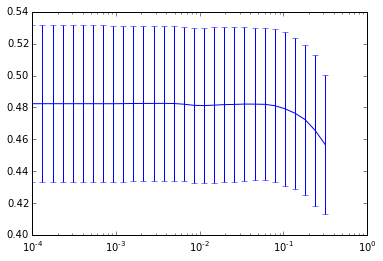

In [47]:
plt.errorbar(alphas, m, yerr=s)
plt.semilogx()

In [48]:
alphas[np.argmax(m)]

0.0037065129109221566

In [49]:
alphas

array([  1.00000000e-04,   1.32035178e-04,   1.74332882e-04,
         2.30180731e-04,   3.03919538e-04,   4.01280703e-04,
         5.29831691e-04,   6.99564216e-04,   9.23670857e-04,
         1.21957046e-03,   1.61026203e-03,   2.12611233e-03,
         2.80721620e-03,   3.70651291e-03,   4.89390092e-03,
         6.46167079e-03,   8.53167852e-03,   1.12648169e-02,
         1.48735211e-02,   1.96382800e-02,   2.59294380e-02,
         3.42359796e-02,   4.52035366e-02,   5.96845700e-02,
         7.88046282e-02,   1.04049831e-01,   1.37382380e-01,
         1.81393069e-01,   2.39502662e-01,   3.16227766e-01])